In [ ]:
!pip install visualtorch

In [ ]:
"""
import torch
import torch.nn.functional as F
from torch_geometric_temporal import ASTGCN
from torch_geometric_temporal.signal import temporal_signal_split
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal import ASTGCN
from torch_geometric.utils import dense_to_sparse  # for converting dense A → sparse edges
# 1. Prepare device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Prepare the graph
locations = {
    "Data_สถานีชาร์จ": (13.73624, 100.52995),
    "Data_อาคารจามจุรี4": (13.73260, 100.53177),
    "Data_อาคารจามจุรี 9": (13.73380, 100.53045),
    "Data_อาคารจุลจักรพงษ์": (13.73684, 100.52852),
    "Data_อาคารบรมราชกุมารี": (13.73800, 100.52905),
    "Data_อาคารวิทยนิเวศน์": (13.73723, 100.53015),
}
station_names = list(locations.keys())
num_nodes = len(station_names)

# Build a fully-connected edge_index
edge_index = torch.tensor(
    [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
    dtype=torch.long,
).t().contiguous().to(device)  # ← move to GPU here

# 3. Pivot utility
def pivot_to_tensor(df, seq_len):
    df_pivot = df.pivot(index='Date', columns='station_name', values='Electricity(kW)')
    df_pivot = df_pivot[station_names].fillna(0.)
    windows = []
    for start in range(len(df_pivot) - seq_len + 1):
        win = df_pivot.iloc[start:start+seq_len].values  # (seq_len, N)
        windows.append(win.T)                            # (N, seq_len)
    arr = np.stack(windows, axis=0)                     # (T, N, seq_len)
    return torch.tensor(arr, dtype=torch.float)

# 4. Data preparation
len_input = 96
prediction_length = 96
X = pivot_to_tensor(train_df, len_input + prediction_length)
X_input = X[:, :, :len_input]      # (T, N, len_input)
X_target = X[:, :, len_input:]     # (T, N, prediction_length)

class TemporalDataset(torch.utils.data.Dataset):
    def __init__(self, X_in, X_out):
        self.X_in = X_in
        self.X_out = X_out
    def __len__(self):
        return len(self.X_in)
    def __getitem__(self, idx):
        return self.X_in[idx], self.X_out[idx]

dataset = TemporalDataset(X_input, X_target)
loader = DataLoader(dataset, batch_size=512, shuffle=True)
# Config dictionary for ASTGCN hyperparameters



class ASTGCN_V2(nn.Module):
    def __init__(self, num_nodes: int, **kwargs):
        super().__init__()
        self.astgcn = ASTGCN(**kwargs)
        # learnable factors to build A_adp = softmax(ReLU(emb1 @ emb2))
        self.node_emb1 = nn.Parameter(torch.randn(num_nodes, 10))
        self.node_emb2 = nn.Parameter(torch.randn(10, num_nodes))

    def forward(self, x, edge_index=None):
        # 1) build adaptive adjacency matrix (dense)
        A_inter = F.relu(self.node_emb1 @ self.node_emb2)   # (N, N)
        A_adp   = F.softmax(A_inter, dim=1)                 # row-normalize

        # 2) convert to sparse edge_index (drop weights)
        edge_index_adp, _ = dense_to_sparse(A_adp)          #  [oai_citation:0‡pytorch-geometric-temporal.readthedocs.io](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html?utm_source=chatgpt.com)

        # 3) feed into ASTGCN (which expects only edge_index)  [oai_citation:1‡pytorch-geometric-temporal.readthedocs.io](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html?utm_source=chatgpt.com)
        out = self.astgcn(x, edge_index_adp)

        return F.relu(out)
# 5. Instantiate and move model to GPU
# Define your config as before
astgcn_config = {
    "nb_block": 2,
    "in_channels": 1,
    "K": 2,
    "nb_chev_filter": 64,
    "nb_time_filter": 64,
    "time_strides": 1,
    "num_for_predict": prediction_length,
    "len_input": len_input,
    "num_of_vertices": num_nodes,
    "normalization": "sym",
    "bias": True,
}
# 1) Model, loss, optimizer, scheduler, scaler
model     = ASTGCN_V2(**astgcn_config, num_nodes=num_nodes).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-2,
    steps_per_epoch=len(loader),
    epochs=30,
    pct_start=0.3   # optional: gentle warm-up
)
scaler    = GradScaler()

# 2) Training loop
model.train()
for epoch in range(1):
    total_loss = 0.0
    # iterate over DataLoader directly
    for X_batch, Y_batch in tqdm(loader, desc=f"Epoch {epoch+1:02d}"):
        X = X_batch.unsqueeze(2).to(device)  # [B, N, 1, len_input]
        Y = Y_batch.to(device)               # [B, N, pred_len]

        optimizer.zero_grad()
        with autocast():
            y_pred = model(X, edge_index)
            loss   = criterion(y_pred, Y)

        # 1) backward with scaler
        scaler.scale(loss).backward()
        # 2) un-scale then clip
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # 3) optimizer step + scaler update
        scaler.step(optimizer)
        scaler.update()
        # 4) scheduler step (per-batch)
        scheduler.step()

        total_loss += loss.item()

    avg = total_loss / len(loader)
    print(f"Epoch {epoch+1:02d} — Avg Loss: {avg:.4f}")
"""
from this model architecture, apply visualtorch library, to plot the arhictecture like in paper style

In [1]:
!pip install scikit-learn pandas numpy torchview visualtorch gdown torch-geometric-temporal torch-cluster # then restart

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:0

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal import ASTGCN
from torch_geometric.utils import dense_to_sparse
import visualtorch

# Define the ASTGCN_V2 model (same as provided)
class ASTGCN_V2(nn.Module):
    def __init__(self, num_nodes: int, **kwargs):
        super().__init__()
        self.astgcn = ASTGCN(**kwargs)
        self.node_emb1 = nn.Parameter(torch.randn(num_nodes, 10))
        self.node_emb2 = nn.Parameter(torch.randn(10, num_nodes))

    def forward(self, x, edge_index=None):
        A_inter = F.relu(self.node_emb1 @ self.node_emb2)
        A_adp = F.softmax(A_inter, dim=1)
        edge_index_adp, _ = dense_to_sparse(A_adp)
        out = self.astgcn(x, edge_index_adp)
        return F.relu(out)

# Configuration for ASTGCN
astgcn_config = {
    "nb_block": 2,
    "in_channels": 1,
    "K": 2,
    "nb_chev_filter": 64,
    "nb_time_filter": 64,
    "time_strides": 1,
    "num_for_predict": 96,
    "len_input": 96,
    "num_of_vertices": 6,
    "normalization": "sym",
    "bias": True,
}

# Initialize the model
num_nodes = 6
model = ASTGCN_V2(num_nodes=num_nodes, **astgcn_config)

# Define input shape for visualization (batch_size, num_nodes, in_channels, len_input)
input_shape = (512, num_nodes, 1, 96)

# Visualize the model using visualtorch's LayeredView
img = visualtorch.graph_view(
    model,
    input_shape=input_shape,
    # legend=True

)
import matplotlib.pyplot as plt

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()

KeyError: '138140323920432'

In [32]:
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

In [30]:
plt.savefig("astgcn_model.pdf", format="pdf", bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

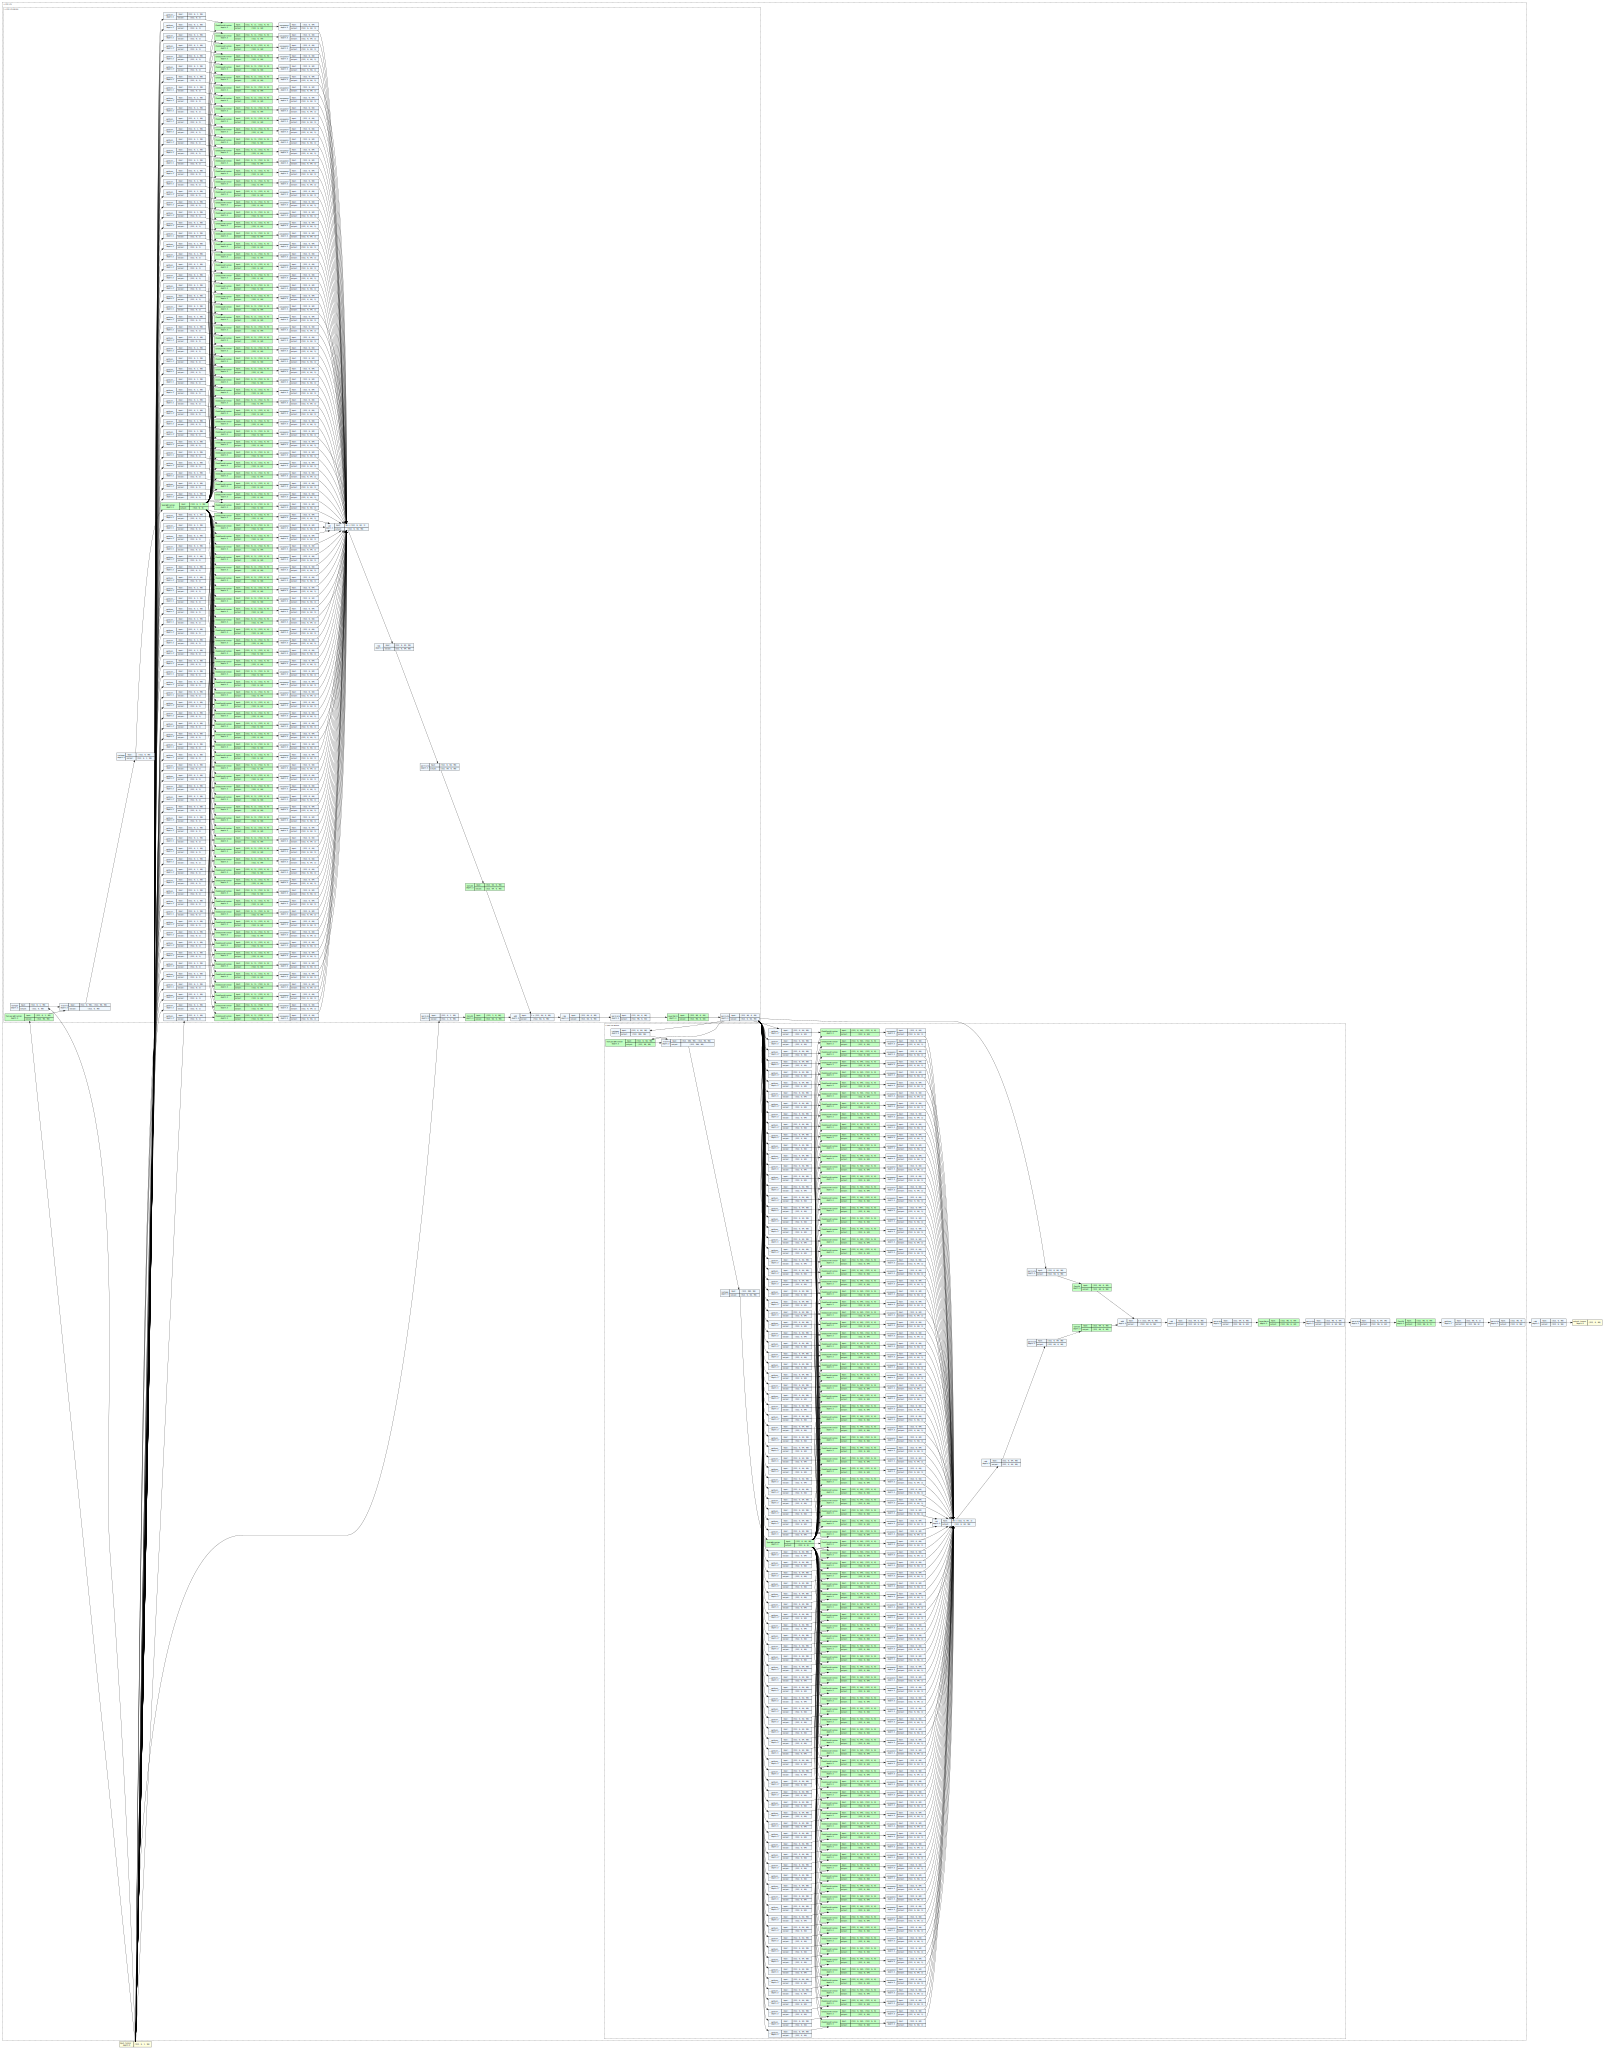

In [23]:
from torchview import draw_graph

# Wrap the model with input example
model_graph = draw_graph(
    model,
    input_data=torch.rand(*input_shape),
    graph_dir="LR",
    save_graph=False,
    expand_nested=False,
)

model_graph.visual_graph

In [21]:
model_graph.visual_graph.render()

'model.gv.pdf'